<a href="https://colab.research.google.com/github/HealMaDe/ViT_Patch_Trial/blob/main/Retinamnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.cuda.is_available():
    print("✅ GPU detected")
    print("Device name:", torch.cuda.get_device_name(0))
    print("Memory allocated:", round(torch.cuda.memory_allocated(0)/1024**2, 1), "MB")
    print("Memory reserved:", round(torch.cuda.memory_reserved(0)/1024**2, 1), "MB")
else:
    print("❌ No GPU detected, using CPU")


✅ GPU detected
Device name: Tesla T4
Memory allocated: 0.0 MB
Memory reserved: 0.0 MB


In [ ]:
import os, time, csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import timm
import numpy as np
from PIL import Image
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# -------------------------
# 1. Setup
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
IMG_SIZE = 28  # original size
EPOCHS = 120
LR = 1e-4
DATA_PATH = "./retinamnist.npz"
SAVE_DIR = "./results_retina"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
model_name = "vit_tiny_patch16_224" # or vit_small_patch16_224, vit_base_patch16_224
patch_size = 28, #try  14,7,4,2,1

In [ ]:
# -------------------------
# Dataset
# -------------------------
class RetinaMNISTDataset(Dataset):
    def __init__(self, split, npz_path=DATA_PATH, transform=None):
        data = np.load(npz_path)
        if split == "train":
            self.images, self.labels = data["train_images"], data["train_labels"]
        elif split == "val":
            self.images, self.labels = data["val_images"], data["val_labels"]
        elif split == "test":
            self.images, self.labels = data["test_images"], data["test_labels"]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

        self.labels = self.labels.reshape(-1)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # already RGB
        label = int(self.labels[idx])

        img = Image.fromarray((img * 255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        return img, label


# -------------------------
# augmentation
# -------------------------
train_transform = T.Compose([
    T.RandomResizedCrop(28, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.ToTensor()
])

val_transform = T.Compose([
    T.ToTensor()
])


train_ds = RetinaMNISTDataset("train", transform=train_transform)
val_ds   = RetinaMNISTDataset("val", transform=val_transform)
test_ds  = RetinaMNISTDataset("test", transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_ds.labels.flatten()))  # should be 5



def get_model(model_name="vit_base_patch16_224", patch_size=28, img_size=28):
    if isinstance(img_size, int):
        img_size = (img_size, img_size)
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=NUM_CLASSES,
        patch_size=patch_size,
        img_size=img_size
    )
    return model.to(DEVICE)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    epoch_time = time.time() - t0
    return running_loss / total, correct / total, epoch_time


@torch.no_grad()
def evaluate(model, loader, criterion, save_csv=None):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds_class = []
    all_probs = []

    # sync for accurate timing on GPU
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()

    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * imgs.size(0)
        preds_class = outputs.argmax(1)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds_class.extend(preds_class.cpu().numpy().tolist())
        # for binary: save prob of positive class; for multiclass save the whole row
        if probs.shape[1] == 2:
            all_probs.extend(probs[:, 1].tolist())          # (N,) list of positive prob
        else:
            all_probs.extend(probs.tolist())                # list of lists (N, C)

    if DEVICE == "cuda":
        torch.cuda.synchronize()
    elapsed = time.time() - t0
    fps = len(all_labels) / elapsed if elapsed > 0 else 0.0

    acc = np.mean(np.array(all_labels) == np.array(all_preds_class))
    bal_acc = balanced_accuracy_score(all_labels, all_preds_class)

    # compute AUC
    try:
        if NUM_CLASSES == 2:
            auc = roc_auc_score(all_labels, np.array(all_probs))  # probs is (N,) for positive class
        else:
            auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='macro')
    except Exception as e:
        print("roc_auc_score error:", e)
        auc = 0.0

    # save predictions & probs
    if save_csv is not None:
        with open(save_csv, "w", newline="") as f:
            writer = csv.writer(f)
            if NUM_CLASSES == 2:
                writer.writerow(["label", "pred_class", "prob_pos"])
                for y, phat, ppos in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat, ppos])
            else:
                writer.writerow(["label", "pred_class"] + [f"prob_{i}" for i in range(NUM_CLASSES)])
                for y, phat, probs_row in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat] + probs_row)

    return running_loss / len(loader.dataset), acc, bal_acc, auc, elapsed, fps

def run_experiment(model_name, patch_size):
    print(f"\n===== Training {model_name} with patch size {patch_size} (input {IMG_SIZE}) =====")
    model = get_model(model_name, patch_size=patch_size, img_size=IMG_SIZE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

    #StepLR scheduler (reduce LR by 0.5 every 30 epochs) ---
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}

    best_val_loss = float("inf")   # track best by validation loss
    best_ckpt = None

    # reset peak memory statistics only if CUDA available
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()

    total_train_time = 0.0
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc, epoch_time = train_one_epoch(model, train_loader, optimizer, criterion)
        total_train_time += epoch_time
        val_loss, val_acc, val_bal_acc, val_auc, _, _ = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch}/{EPOCHS} "
              f"| LR {optimizer.param_groups[0]['lr']:.2e} "
              f"| Train loss {train_loss:.4f} acc {train_acc:.4f} "
              f"| Val loss {val_loss:.4f} acc {val_acc:.4f} bal_acc {val_bal_acc:.4f} auc {val_auc:.4f} "
              f"| epoch_time {epoch_time:.2f}s")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

        # --- Save best checkpoint by lowest validation loss ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_ckpt = f"{SAVE_DIR}/best_{model_name}_p{patch_size}_28.pth"
            torch.save(model.state_dict(), best_ckpt)

        # --- Step scheduler ---
        scheduler.step()

    # load best and evaluate on test set
    if best_ckpt is None:
        print("No checkpoint saved (no improvement). Using last model weights.")
        best_ckpt = f"{SAVE_DIR}/last_{model_name}_p{patch_size}_28.pth"
        torch.save(model.state_dict(), best_ckpt)

    model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))

    test_loss, test_acc, test_bal_acc, test_auc, test_time, fps = evaluate(
        model, test_loader, criterion,
        save_csv=f"{SAVE_DIR}/preds_{model_name}_p{patch_size}_28.csv"
    )

    peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2) if DEVICE == "cuda" else "N/A"

    print("\n=== Final test results ===")
    print(f"Model: {model_name}  patch: {patch_size}  input: {IMG_SIZE}")
    print(f"Test loss: {test_loss:.4f}  acc: {test_acc:.4f}  bal_acc: {test_bal_acc:.4f}  auc: {test_auc:.4f}")
    print(f"Total train time: {total_train_time:.2f}s  Test time: {test_time:.2f}s  Inference FPS: {fps:.2f}")
    print(f"Peak VRAM (MB): {peak_vram_mb}\n")

    # --- Plot curves ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Val")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history["val_auc"], label="Val AUC")
    plt.title("Validation AUC"); plt.xlabel("Epoch"); plt.legend()

    plt.tight_layout()
    plot_path = f"{SAVE_DIR}/curves_{model_name}_p{patch_size}_28.png"
    plt.savefig(plot_path)

    #plt.close()
    print(f"Saved training curves to {plot_path}")
    plt.show()


===== Training vit_tiny_patch16_224 with patch size 28 (input 28) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 1.4153 acc 0.4426 | Val loss 1.2420 acc 0.4833 bal_acc 0.2423 auc 0.7486 | epoch_time 5.03s
Epoch 2/120 | LR 1.00e-04 | Train loss 1.3169 acc 0.4417 | Val loss 1.1883 acc 0.4417 bal_acc 0.2032 auc 0.7401 | epoch_time 3.82s
Epoch 3/120 | LR 1.00e-04 | Train loss 1.3015 acc 0.4694 | Val loss 1.2085 acc 0.4000 bal_acc 0.2556 auc 0.7280 | epoch_time 4.09s
Epoch 4/120 | LR 1.00e-04 | Train loss 1.2883 acc 0.4833 | Val loss 1.1593 acc 0.4833 bal_acc 0.3098 auc 0.7202 | epoch_time 3.73s
Epoch 5/120 | LR 1.00e-04 | Train loss 1.3067 acc 0.4463 | Val loss 1.2143 acc 0.4750 bal_acc 0.3244 auc 0.7377 | epoch_time 3.90s
Epoch 6/120 | LR 1.00e-04 | Train loss 1.2645 acc 0.4759 | Val loss 1.1405 acc 0.4750 bal_acc 0.3033 auc 0.7355 | epoch_time 4.08s
Epoch 7/120 | LR 1.00e-04 | Train loss 1.2749 acc 0.4750 | Val loss 1.1448 acc 0.5083 bal_acc 0.3256 auc 0.7506 | epoch_time 4.91s
Epoch 8/120 | LR 1.00e-04 | Train loss 1.2543 acc 0.4898 | Val loss 1.1343 acc 0.50

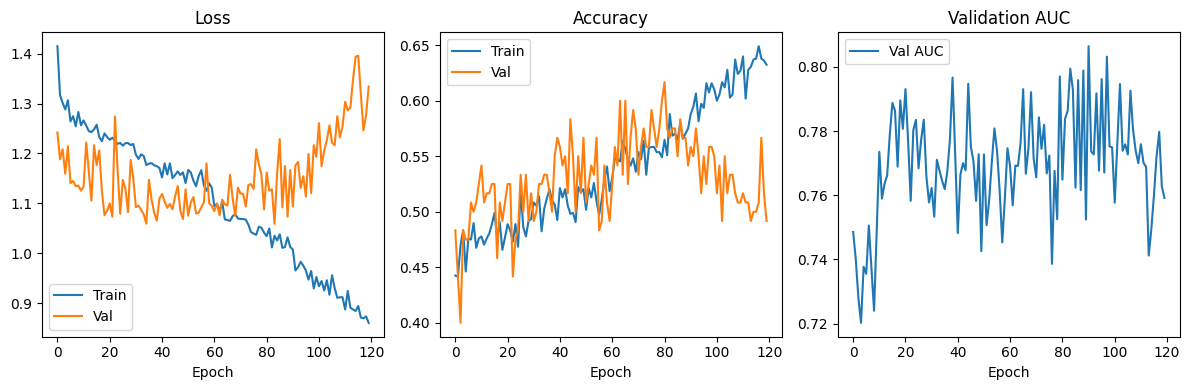


===== Training vit_tiny_patch16_224 with patch size 14 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 1.4195 acc 0.4315 | Val loss 1.2682 acc 0.4500 bal_acc 0.2751 auc 0.7327 | epoch_time 4.38s
Epoch 2/120 | LR 1.00e-04 | Train loss 1.3163 acc 0.4685 | Val loss 1.1908 acc 0.4833 bal_acc 0.3281 auc 0.7362 | epoch_time 3.66s
Epoch 3/120 | LR 1.00e-04 | Train loss 1.2882 acc 0.4565 | Val loss 1.1856 acc 0.4917 bal_acc 0.3416 auc 0.7631 | epoch_time 3.67s
Epoch 4/120 | LR 1.00e-04 | Train loss 1.2860 acc 0.4574 | Val loss 1.2349 acc 0.5083 bal_acc 0.3330 auc 0.7632 | epoch_time 4.31s
Epoch 5/120 | LR 1.00e-04 | Train loss 1.2843 acc 0.4630 | Val loss 1.2070 acc 0.4917 bal_acc 0.3130 auc 0.7612 | epoch_time 3.65s
Epoch 6/120 | LR 1.00e-04 | Train loss 1.2748 acc 0.4806 | Val loss 1.2125 acc 0.5083 bal_acc 0.3519 auc 0.7651 | epoch_time 3.74s
Epoch 7/120 | LR 1.00e-04 | Train loss 1.2718 acc 0.4602 | Val loss 1.1414 acc 0.4583 bal_acc 0.2730 auc 0.7605 | epoch_time 4.39s
Epoch 8/12

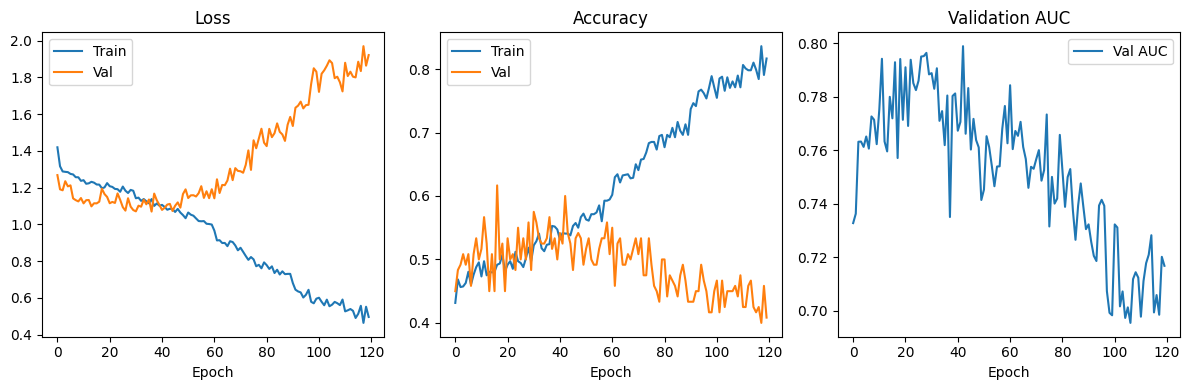


===== Training vit_tiny_patch16_224 with patch size 7 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 1.4082 acc 0.4361 | Val loss 1.2287 acc 0.4500 bal_acc 0.2000 auc 0.7624 | epoch_time 4.34s
Epoch 2/120 | LR 1.00e-04 | Train loss 1.3318 acc 0.4306 | Val loss 1.1205 acc 0.4583 bal_acc 0.2347 auc 0.7732 | epoch_time 3.66s
Epoch 3/120 | LR 1.00e-04 | Train loss 1.2790 acc 0.4620 | Val loss 1.1778 acc 0.4250 bal_acc 0.1889 auc 0.7562 | epoch_time 3.66s
Epoch 4/120 | LR 1.00e-04 | Train loss 1.2843 acc 0.4750 | Val loss 1.2404 acc 0.5333 bal_acc 0.3826 auc 0.7534 | epoch_time 4.22s
Epoch 5/120 | LR 1.00e-04 | Train loss 1.2567 acc 0.4843 | Val loss 1.1444 acc 0.5333 bal_acc 0.3963 auc 0.7612 | epoch_time 3.75s
Epoch 6/120 | LR 1.00e-04 | Train loss 1.2706 acc 0.4667 | Val loss 1.2484 acc 0.4833 bal_acc 0.3302 auc 0.7415 | epoch_time 3.71s
Epoch 7/120 | LR 1.00e-04 | Train loss 1.2314 acc 0.4870 | Val loss 1.2630 acc 0.4833 bal_acc 0.3476 auc 0.7568 | epoch_time 4.21s
Epoch 8/120

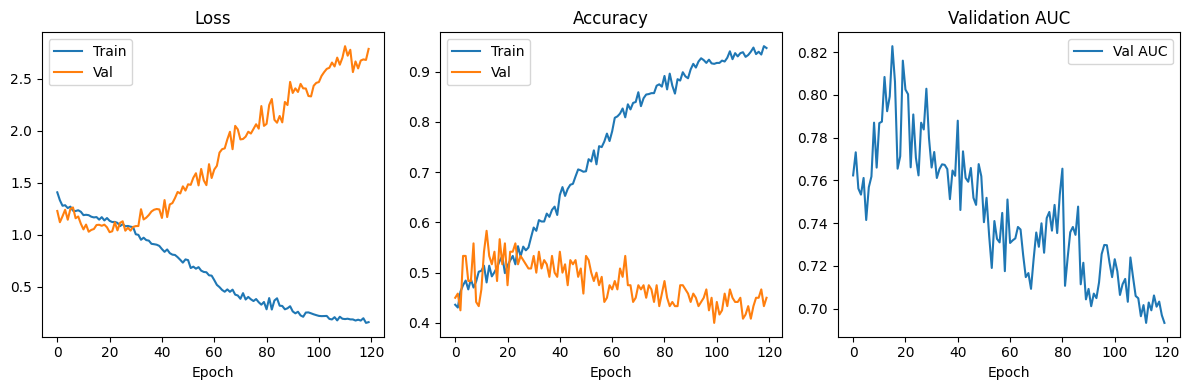


===== Training vit_tiny_patch16_224 with patch size 4 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 1.4165 acc 0.4417 | Val loss 1.2104 acc 0.4667 bal_acc 0.2893 auc 0.7333 | epoch_time 3.73s
Epoch 2/120 | LR 1.00e-04 | Train loss 1.2976 acc 0.4759 | Val loss 1.2300 acc 0.4667 bal_acc 0.3344 auc 0.7729 | epoch_time 4.38s
Epoch 3/120 | LR 1.00e-04 | Train loss 1.2679 acc 0.4620 | Val loss 1.1345 acc 0.5000 bal_acc 0.2807 auc 0.7642 | epoch_time 3.69s
Epoch 4/120 | LR 1.00e-04 | Train loss 1.2523 acc 0.4583 | Val loss 1.1436 acc 0.5000 bal_acc 0.3101 auc 0.7551 | epoch_time 3.69s
Epoch 5/120 | LR 1.00e-04 | Train loss 1.2352 acc 0.4667 | Val loss 1.3970 acc 0.4083 bal_acc 0.3333 auc 0.7690 | epoch_time 4.37s
Epoch 6/120 | LR 1.00e-04 | Train loss 1.2551 acc 0.4639 | Val loss 1.1825 acc 0.4333 bal_acc 0.3404 auc 0.7754 | epoch_time 3.63s
Epoch 7/120 | LR 1.00e-04 | Train loss 1.2157 acc 0.4963 | Val loss 1.1462 acc 0.4083 bal_acc 0.1878 auc 0.7750 | epoch_time 3.76s
Epoch 8/120

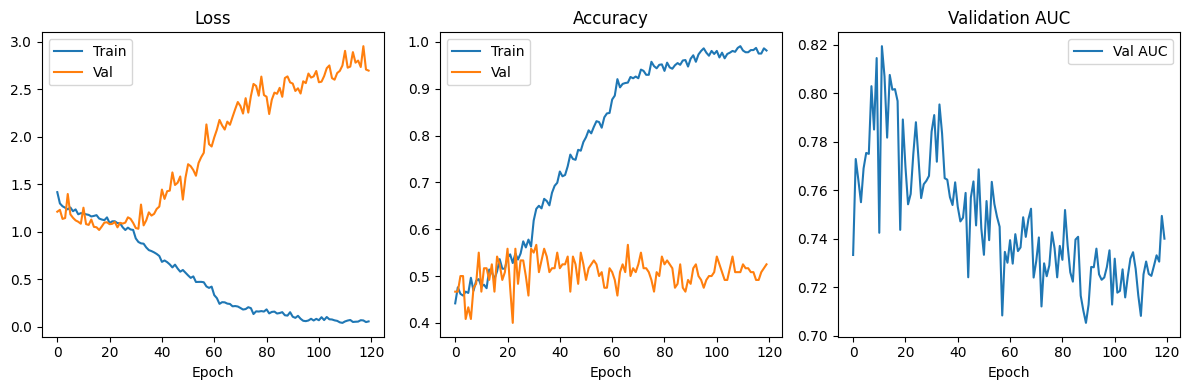


===== Training vit_tiny_patch16_224 with patch size 2 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 1.4067 acc 0.4509 | Val loss 1.2523 acc 0.4750 bal_acc 0.3056 auc 0.7384 | epoch_time 4.98s
Epoch 2/120 | LR 1.00e-04 | Train loss 1.3152 acc 0.4509 | Val loss 1.1153 acc 0.4500 bal_acc 0.2241 auc 0.7555 | epoch_time 5.28s
Epoch 3/120 | LR 1.00e-04 | Train loss 1.3144 acc 0.4444 | Val loss 1.2218 acc 0.4833 bal_acc 0.3156 auc 0.7880 | epoch_time 5.03s
Epoch 4/120 | LR 1.00e-04 | Train loss 1.2970 acc 0.4685 | Val loss 1.2676 acc 0.4500 bal_acc 0.3259 auc 0.7626 | epoch_time 5.14s
Epoch 5/120 | LR 1.00e-04 | Train loss 1.2540 acc 0.4815 | Val loss 1.1543 acc 0.4583 bal_acc 0.2793 auc 0.7704 | epoch_time 5.09s
Epoch 6/120 | LR 1.00e-04 | Train loss 1.2582 acc 0.4676 | Val loss 1.1432 acc 0.4833 bal_acc 0.3156 auc 0.7614 | epoch_time 4.98s
Epoch 7/120 | LR 1.00e-04 | Train loss 1.2481 acc 0.4917 | Val loss 1.0908 acc 0.5083 bal_acc 0.2701 auc 0.7771 | epoch_time 5.19s
Epoch 8/120

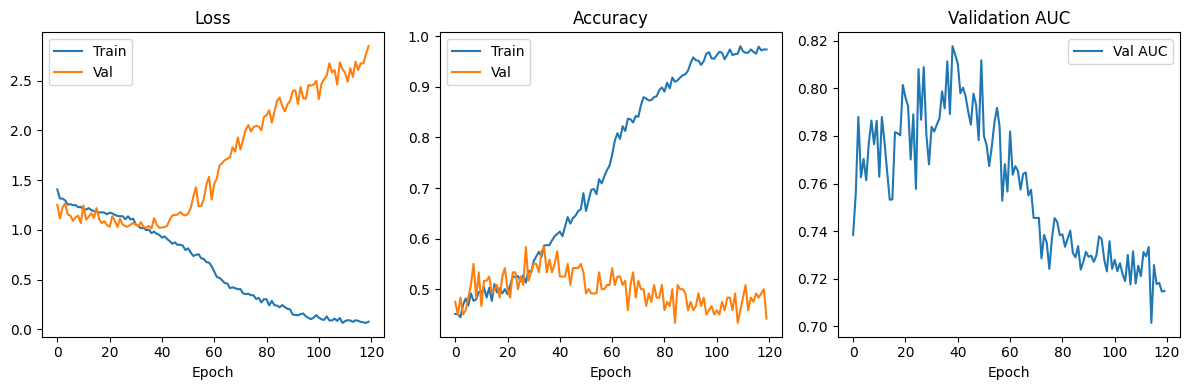


===== Training vit_tiny_patch16_224 with patch size 1 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 1.4092 acc 0.4361 | Val loss 1.2745 acc 0.5333 bal_acc 0.3299 auc 0.7688 | epoch_time 23.28s
Epoch 2/120 | LR 1.00e-04 | Train loss 1.3277 acc 0.4472 | Val loss 1.1167 acc 0.4583 bal_acc 0.2415 auc 0.7523 | epoch_time 23.26s
Epoch 3/120 | LR 1.00e-04 | Train loss 1.2801 acc 0.4611 | Val loss 1.1991 acc 0.4500 bal_acc 0.2000 auc 0.7484 | epoch_time 23.30s
Epoch 4/120 | LR 1.00e-04 | Train loss 1.2641 acc 0.4750 | Val loss 1.1579 acc 0.4583 bal_acc 0.2071 auc 0.8009 | epoch_time 23.27s
Epoch 5/120 | LR 1.00e-04 | Train loss 1.2358 acc 0.4806 | Val loss 1.1210 acc 0.4583 bal_acc 0.3498 auc 0.7763 | epoch_time 23.26s
Epoch 6/120 | LR 1.00e-04 | Train loss 1.2194 acc 0.5074 | Val loss 1.2550 acc 0.4917 bal_acc 0.3676 auc 0.7630 | epoch_time 23.29s
Epoch 7/120 | LR 1.00e-04 | Train loss 1.2390 acc 0.4759 | Val loss 1.1224 acc 0.4250 bal_acc 0.3342 auc 0.7835 | epoch_time 23.27s
Epoc

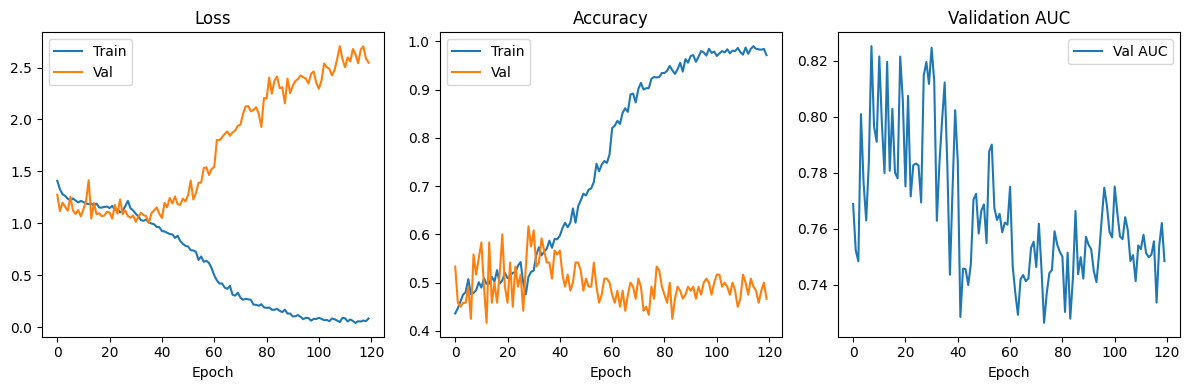

In [ ]:
if __name__ == "__main__":
    for p in [28,14,7,4,2,1]:
        run_experiment(model_name, patch_size=p)
